<a href="https://colab.research.google.com/github/Pinkysol/Learning/blob/main/25_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе необходимо с помощью **AutoKeras или KerasTuner** найти оптимальную модель для решения одной из следующих задач:

1. На 3 балла. **Обучи** модель с точностью не менее 90% предсказывать сарказм в новостных заголовках. **Составь** 5 произвольных заголовков, которых нет в датасете и **проверь** на них обученную модель, сделай выводы. [Ссылка на датасет](https://storage.yandexcloud.net/academy.ai/Sarcasm_Headlines_Dataset_v2.json.zip)
2. На 4 балла. **Используй** [русский корпус новостей от Lenta.ru](https://www.kaggle.com/datasets/yutkin/corpus-of-russian-news-articles-from-lenta/data) **подбери** и **обучи** модель классифицировать новости по заголовкам на классы (поле topic в датасете). **Используй** 9 самых часто встречаемых топиков и 10-й для остальных, не вошедших в 9 классов. **Оцени** модель с помощью отчета о классификации, **сделай** выводы.
3. На 5 баллов. **Найди** публичный датасет по обращениям граждан в администрацию, техническую поддержку или за консультацией. **Обучи** модель классифицировать обращения по тематикам. **Сформируй** отчет о классификации и матрицу ошибок.

In [ ]:
!wget https://storage.yandexcloud.net/quiz-bucket-pinkysoul/archive.zip
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "archive.zip" -d ./dataset

--2025-04-03 00:03:56--  https://storage.yandexcloud.net/quiz-bucket-pinkysoul/archive.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 847457 (828K) [application/x-zip-compressed]
Saving to: ‘archive.zip.12’

archive.zip.12      100%[===================>] 827.59K  2.73MB/s    in 0.3s    

2025-04-03 00:03:57 (2.73 MB/s) - ‘archive.zip.12’ saved [847457/847457]



In [ ]:
import tensorflow as tf
import keras_nlp as nlp
# Библиотека матричного вычисления
import numpy as np
# Библиотека для работы с данными
import pandas as pd
# Библиотека для работы с регулярными выражениями
import re
# Библиотека для работы с фреймворком TensorFlow
import tensorflow as tf
# Библиотека AutoML autokeras
import autokeras as ak
# Библиотеки для построения графиков и их стилизации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Утилита для расщепления выборки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Необходимые метрики для построения Матрицы ошибок и отчета о классификации
from sklearn.metrics import classification_report, confusion_matrix

# Импортируем фреймворк Keras
import keras

# Для работы с слоями
from keras import layers

# Тюнеры для KerasTuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Для быстрой векторизации слов
from tensorflow.keras.preprocessing.text import one_hot

# Выравнивание последовательностей по длиине
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
address = "./dataset/customer_support_tickets.csv"
json_df = pd.read_csv(address) # библиотека pandas умеет работать с json данными
df_support_tickets = pd.DataFrame(json_df) # создаем датафрейм
df_support_tickets = df_support_tickets.dropna() # удалим пустые значения
df_support_tickets.head() # выводим первые 5 записей датафрейма


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0
10,11,Joseph Moreno,mbrown@example.org,48,Male,Nintendo Switch,2021-01-19,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,2023-06-01 17:46:49,2023-05-31 23:51:49,1.0
11,12,Brandon Arnold,davisjohn@example.net,51,Male,Microsoft Xbox Controller,2021-10-24,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,2023-06-01 12:05:51,2023-06-01 09:27:51,1.0


In [ ]:
# Создание значения класса по значению столбца Customer Satisfaction Rating
def rating_change(row):
  if row['Customer Satisfaction Rating']<=2:
      return 'Low'
  elif row['Customer Satisfaction Rating']==3:
      return 'Medium'
  else:
      return 'High'

# Создание значения класса по значению столбца Customer Age
def age_change(row):
  if row['Customer Age']<=30:
      return 'Young'
  elif row['Customer Age']<55:
      return 'Middle age'
  else:
      return 'Old'

# Применение функций к строкам датафрейма
df_support_tickets['Rating'] = df_support_tickets.apply(rating_change, axis=1)
df_support_tickets = df_support_tickets.drop('Customer Satisfaction Rating', axis=1)

df_support_tickets['Age'] = df_support_tickets.apply(age_change, axis=1)
df_support_tickets = df_support_tickets.drop('Customer Age', axis=1)

In [ ]:
# кодируем метки в числовые значения
label = df_support_tickets[['Customer Gender', 'Ticket Type', 'Ticket Subject', 'Ticket Priority', 'Ticket Channel', 'Age']]
encoder = LabelEncoder()
for col in label:
    value = np.unique(df_support_tickets[col])
    df_support_tickets[col] = encoder.fit_transform(df_support_tickets[col])
    encode_value = encoder.transform(value)

In [ ]:
# Создаем таблицы для входных данных
y = df_support_tickets['Rating']
X = df_support_tickets.drop(columns = ['Ticket ID', 'Customer Name', 'Customer Email', 'Product Purchased', 'Date of Purchase',
                                 'Ticket Description', 'Ticket Status', 'First Response Time', 'Time to Resolution',
                                 'Resolution'], axis = 1)

In [ ]:
# Обущающая выборка и временная выборка для содания тестовой и валидационной
X_train, X_tmp, y_train, y_tmp = train_test_split(X,
  y, test_size=0.2, stratify=y, random_state=42)
# Тестовая и валидационная выборка
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)

In [ ]:
# Для экономии ОЗУ удаляем уже ненужные данные, после чего python запускает сборщик "мусора" для очистки памяти
del df_support_tickets, X_tmp, y_tmp

In [ ]:
# Входной слой структуризированных данных
input_node = ak.StructuredDataInput()
# Здесь идет подбор слоев для работы со структуризированными данными
output_node = ak.StructuredDataBlock(input_node)
# Выходной слой должен обеспечивать классификацию
output_node = ak.ClassificationHead(output_node)
# Собираем модель, аналогично как мы это делали для Keras functional API, используем 2 модели (max_trials=2)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True,  max_trials=2, objective='val_accuracy'
)
# Обучаем 2 модели на 20-х эпохах, размер пакета подбирается автоматически
result_training = clf.fit(X_train, y_train, epochs = 20, validation_data = (X_val, y_val))

Trial 2 Complete [00h 00m 12s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 24s
Epoch 1/20
70/70 [==============================] - 1s 8ms/step - loss: 0.9807 - accuracy: 0.5038 - val_loss: 0.5291 - val_accuracy: 0.8773
Epoch 2/20
70/70 [==============================] - 0s 7ms/step - loss: 0.3802 - accuracy: 0.8433 - val_loss: 0.1252 - val_accuracy: 0.9603
Epoch 3/20
70/70 [==============================] - 0s 6ms/step - loss: 0.1633 - accuracy: 0.9391 - val_loss: 0.0800 - val_accuracy: 0.9711
Epoch 4/20
70/70 [==============================] - 0s 7ms/step - loss: 0.1296 - accuracy: 0.9526 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 5/20
70/70 [==============================] - 0s 6ms/step - loss: 0.0785 - accuracy: 0.9725 - val_loss: 0.0235 - val_accuracy: 0.9892
Epoch 6/20
70/70 [==============================] - 0s 6ms/step - loss: 0.0745 - accuracy: 0.9734 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 7/20
70/70 [==============================

INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [ ]:
# Последовательно экспортируем лучшую модель и по ней выводим отчет
clf.export_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 multi_category_encoding (M  (None, 7)                 0         
 ultiCategoryEncoding)                                           
                                                                 
 dense (Dense)               (None, 32)                256       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 re_lu_1 (ReLU)              (None, 32)                0         
                                                             

In [ ]:
# Предсказание на лучшей модели
y_pred = clf.predict(X_test)
# Оценка лучшей модели на тестовых данных
print(clf.evaluate(X_test, y_test))

9/9 [==============================] - 0s 5ms/step - loss: 9.2593e-05 - accuracy: 1.0000
[9.259345097234473e-05, 1.0]


In [ ]:
def plot_graphs(history, key):
    # Используем библиотеку seaborn для задания стиля и цветовой схемы графика
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')

    # Задаем размер полотна для рисования графика
    plt.figure(figsize=(12,6))

    # Отображаем график выбранного параметра
    plt.plot(history.history[key],   # данные для построения графика
             marker='o',             # использовать маркер для точек на графике
             color=palette[2],       # использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          # ширина линии
             label=key)              # подпись легенды

    # График для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], # данные для построения графика
                 marker='o',                  # использовать маркер для точек на графике
                 color=palette[4],            # использовать цвет пятый в палитре
                 linewidth=2.5,               # ширина линии
                 label='val_'+key)            # подпись легенды

    # подпись оси Х, размер шрифта - 12
    plt.xlabel("Эпоха", fontsize=12)
    # подпись оси Y, размер шрифта - 12
    plt.ylabel(key, fontsize=12)

    # подпись заголовка графика, размер шрифта - 14
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14)

    # отображение легенды, размер шрифта - 12
    plt.legend(fontsize=12)

    # задаем сетку на графике
    plt.grid(True)

    # отрисовываем полотно со всеми графиками
    plt.show()

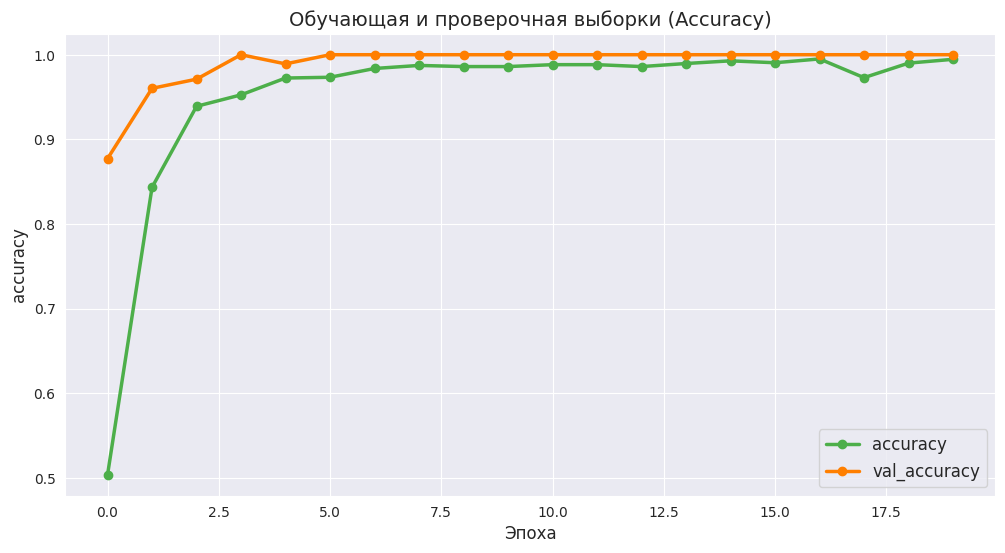

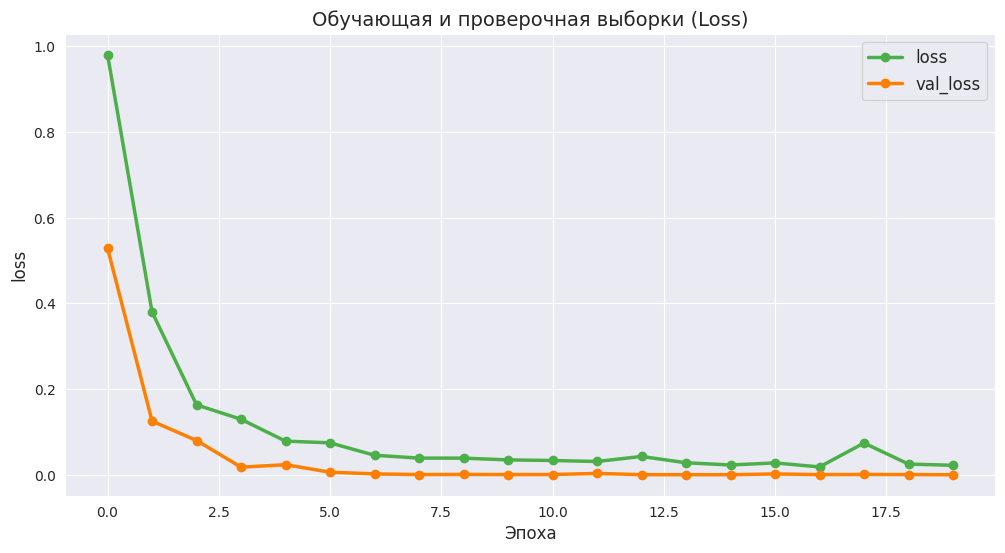

In [ ]:
# строим график точности
plot_graphs(result_training, "accuracy")

# строим график потерь
plot_graphs(result_training, "loss")

In [ ]:
# Отчет классификации для проверки точности
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       109
         Low       1.00      1.00      1.00       110
      Medium       1.00      1.00      1.00        58

    accuracy                           1.00       277
   macro avg       1.00      1.00      1.00       277
weighted avg       1.00      1.00      1.00       277



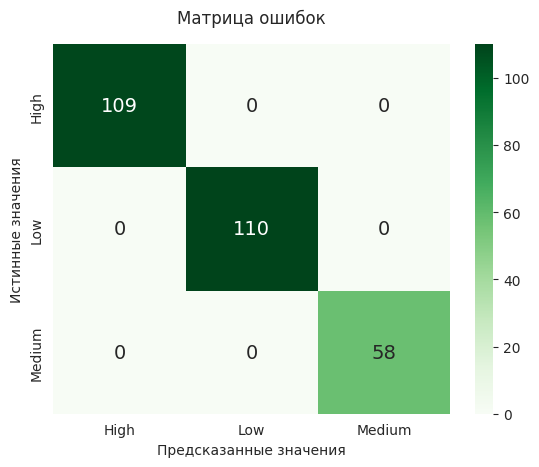

In [ ]:
# Сборка тепловой карты для визуализации матрицы ошибок
sns.heatmap(confusion_matrix(y_test, y_pred, labels=['High','Low','Medium']), annot=True, fmt='d', cmap='Greens', annot_kws={'fontsize': 14},
            xticklabels=['High','Low','Medium'],
            yticklabels=['High','Low','Medium'])
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.title('Матрица ошибок', pad=15)
plt.show()